<a href="https://colab.research.google.com/github/Bidofvic/machine-learning/blob/main/Customer_Segmentation_Using_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Pre-processing**

In [ ]:
# importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt

# Sklearn modules

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Pandas Profiling

!pip install pandas-profiling
import pandas_profiling
import ydata_profiling


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.uploaded = files.upload()


Saving Groceries_dataset.csv to Groceries_dataset.csv


In [ ]:
# read csv file
df = pd.read_csv('/content/Groceries_dataset.csv')

df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [ ]:
df.shape

(38765, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [ ]:
# Checking for Missing values

df.isna()

,Member_number,Date,itemDescription
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
38760,False,False,False
38761,False,False,False
38762,False,False,False
38763,False,False,False


In [ ]:
# Checking for NULL values

df.isnull().any()

Member_number      False
Date               False
itemDescription    False
dtype: bool

In [ ]:
# statistics of the data
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.describe()

,Member_number
count,38765.000000
mean,3003.641868
std,1153.611031
min,1000.000000
25%,2002.000000
50%,3005.000000
75%,4007.000000
max,5000.000000


# Loading the Data Set to SQLite

In [ ]:
# connect to database
conn = sqlite3.connect("GroceryDB")
cur = conn.cursor()

# load CRM data into the GroceryDB.to_sql("groceries", conn) database
df.to_sql("Groceries", conn)

# CHECK IF DATA INSERTED INTO data/GroceryDB
df = pd.read_sql('SELECT * FROM Groceries', conn)
df.tail()

,index,Member_number,Date,itemDescription
38760,38760,4471,08-10-2014,sliced cheese
38761,38761,2022,23-02-2014,candy
38762,38762,1097,16-04-2014,cake bar
38763,38763,1510,03-12-2014,fruit/vegetable juice
38764,38764,1521,26-12-2014,cat food


## Using an SQL Query to Clean the Dataset

In [ ]:
# Execute SQL queries to clean the data

cur.execute('DELETE FROM Groceries WHERE itemdescription IS NULL')

# Commit the changes to the database
conn.commit()

In [ ]:


cleandata = pd.read_sql(''' SELECT
  member_number,
  MAX(date) AS last_order_date,
  COUNT(itemdescription) AS Frequency,
  SUM(member_number) AS Monetary
FROM
  groceries
  WHERE date NOT LIKE '%C%'
  AND member_number IS NOT NULL
GROUP BY
  member_number,
  date
''', conn)


# Write clean CRM data into the database

cleandata.to_sql("cleandata", conn)

14963

In [ ]:
df2 = pd.read_sql('SELECT * FROM cleandata', conn)
df2.head()

,index,Member_number,last_order_date,Frequency,Monetary
0,0,1000,15-03-2015,4,4000
1,1,1000,24-06-2014,3,3000
2,2,1000,24-07-2015,2,2000
3,3,1000,25-11-2015,2,2000
4,4,1000,27-05-2015,2,2000


In [ ]:
df2.dtypes
df2['last_order_date'] = pd.to_datetime(df2['last_order_date'])
df2.dtypes

<ipython-input-15-fc1b523b5db0>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2['last_order_date'] = pd.to_datetime(df2['last_order_date'])


index                       int64
Member_number               int64
last_order_date    datetime64[ns]
Frequency                   int64
Monetary                    int64
dtype: object

In [ ]:
# Create date variable that records recency
import numpy as np
import datetime
df2["last_order_date"] = df2["last_order_date"].dt.date
# Create snapshot date
snapshot_date = df2['last_order_date'].max() + datetime.timedelta(days=1)
print(snapshot_date)
# Aggregate data by each customer
customers = df2.groupby(['Member_number']).agg({
   'last_order_date': lambda x: (snapshot_date - x.max()).days,
   'Frequency':'sum' ,
   'Member_number': 'sum'})

2015-12-31


In [ ]:
# Calculating RFM Values using SQLite and Python

df_ = pd.read_sql(''' SELECT member_number, recency, frequency, monetaryvalue, recency*100 + frequency*10 + monetaryvalue AS combined
    FROM
     ( SELECT member_number,
             NTILE(4) OVER (ORDER BY last_order_date) AS Recency,
             NTILE(4) OVER (ORDER BY Frequency) AS Frequency,
             NTILE(4) OVER (ORDER BY Member_number) AS MonetaryValue
      FROM
            cleandata
            )
 ''', conn)

In [ ]:
df_

,member_number,Recency,Frequency,MonetaryValue,combined
0,1249,1,1,1,111
1,1381,1,1,1,111
2,1440,1,1,1,111
3,1659,1,1,1,111
4,1789,1,1,1,111
...,...,...,...,...,...
14958,2839,4,4,2,442
14959,2627,4,4,2,442
14960,4773,4,4,4,444
14961,2827,4,4,2,442


In [ ]:
def rfm_level(customers):
    if ((customers['Recency'] >= 4) and (customers['Frequency'] >= 4)
        and (customers['MonetaryValue'] >= 4)):
        return 'Best Customers'
    elif ((customers['Recency'] >= 3) and (customers['Frequency'] >= 3)
          and (customers['MonetaryValue'] >= 3)):
        return 'Loyal'
    elif ((customers['Recency'] >= 3) and (customers['Frequency'] >= 1)
          and (customers['MonetaryValue'] >= 2)):
        return 'Potential Loyalist'
    elif ((customers['Recency'] >= 3) and (customers['Frequency'] >= 1)
          and (customers['MonetaryValue'] >= 1)):
        return 'Promising'
    elif ((customers['Recency'] >= 2) and (customers['Frequency'] >= 2)
          and (customers['MonetaryValue'] >= 2)):
        return 'Customers Needing Attention'
    elif ((customers['Recency'] >= 1) and (customers['Frequency'] >= 2)
          and (customers['MonetaryValue'] >= 2)):
        return 'At Risk'
    elif ((customers['Recency'] >= 1) and (customers['Frequency'] >= 1)
          and (customers['MonetaryValue'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'


In [ ]:
# Create a new variable rfm_level

df_['rfm_level'] = df_.apply(rfm_level, axis=1)

df_

,member_number,Recency,Frequency,MonetaryValue,combined,rfm_level
0,1249,1,1,1,111,Lost
1,1381,1,1,1,111,Lost
2,1440,1,1,1,111,Lost
3,1659,1,1,1,111,Lost
4,1789,1,1,1,111,Lost
...,...,...,...,...,...,...
14958,2839,4,4,2,442,Potential Loyalist
14959,2627,4,4,2,442,Potential Loyalist
14960,4773,4,4,4,444,Best Customers
14961,2827,4,4,2,442,Potential Loyalist


In [ ]:
# Calculate total customers in each segment

rfm_agg = df_.groupby('rfm_level').agg({'member_number':'count'})

print(rfm_agg)


                             member_number
rfm_level                                 
At Risk                               2498
Best Customers                         308
Customers Needing Attention           2463
Hibernating                            624
Lost                                  1897
Loyal                                 2199
Potential Loyalist                    3130
Promising                             1844


In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


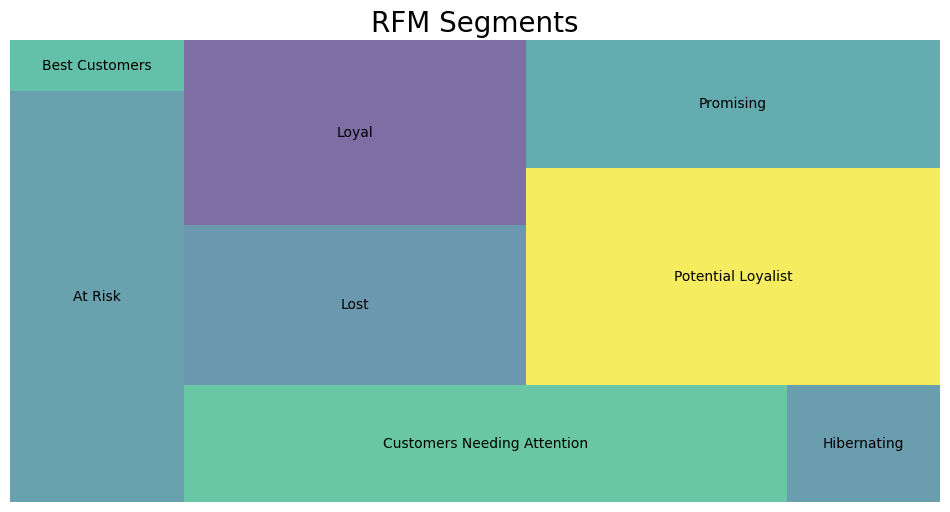

In [ ]:
# RFM visualization

import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 6)
squarify.plot(sizes=rfm_agg['member_number'],
              label=['At Risk',
                     'Best Customers',
                     'Customers Needing Attention',
                     'Hibernating',
                     'Lost',
                     'Loyal',
                     'Potential Loyalist',
                     'Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
# First 5 High-Valued Custommers

df_[df_['MonetaryValue'] >= 3 ].sort_values('combined', ascending=False).head(95)

,member_number,Recency,Frequency,MonetaryValue,combined,rfm_level
14960,4773,4,4,4,444,Best Customers
11387,4422,4,4,4,444,Best Customers
11404,4468,4,4,4,444,Best Customers
11399,4748,4,4,4,444,Best Customers
11398,4295,4,4,4,444,Best Customers
...,...,...,...,...,...,...
13050,4124,4,4,4,444,Best Customers
13031,4662,4,4,4,444,Best Customers
14476,4412,4,4,4,444,Best Customers
13029,4397,4,4,4,444,Best Customers


In [ ]:
# First 5 High-Valued Custommers

df_[df_['combined'] <= 131 ].sort_values('combined', ascending=False).tail(60)

,member_number,Recency,Frequency,MonetaryValue,combined,rfm_level
678,1536,1,1,1,111,Lost
677,1467,1,1,1,111,Lost
676,1001,1,1,1,111,Lost
2159,1369,1,1,1,111,Lost
2160,1480,1,1,1,111,Lost
2262,1742,1,1,1,111,Lost
2275,1461,1,1,1,111,Lost
2506,1025,1,1,1,111,Lost
2384,1472,1,1,1,111,Lost
2386,1492,1,1,1,111,Lost


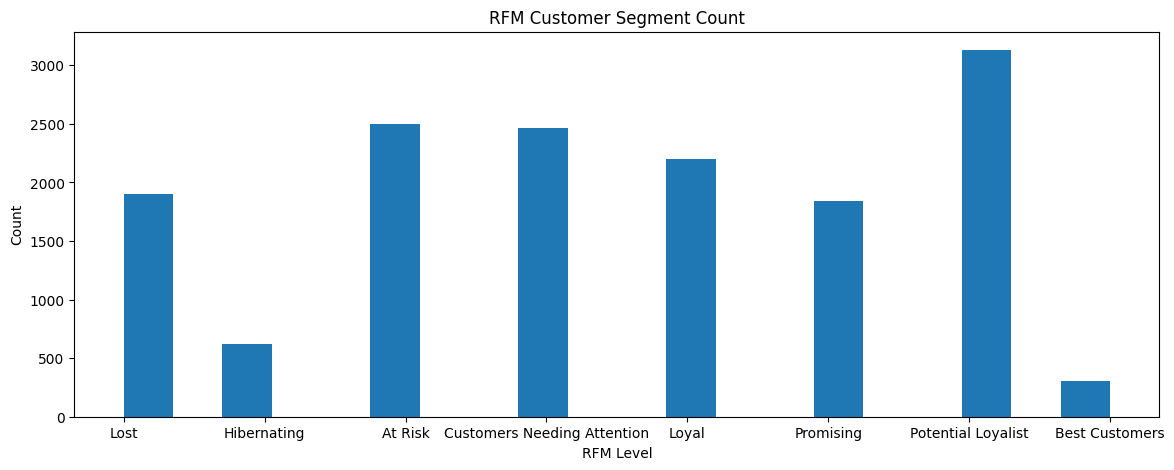

In [ ]:
# Create the histogram
plt.figure(figsize=(14, 5))
plt.hist(df_['rfm_level'], bins=20)
plt.xlabel('RFM Level')
plt.ylabel('Count')
plt.title('RFM Customer Segment Count')
plt.show()

# Correlation

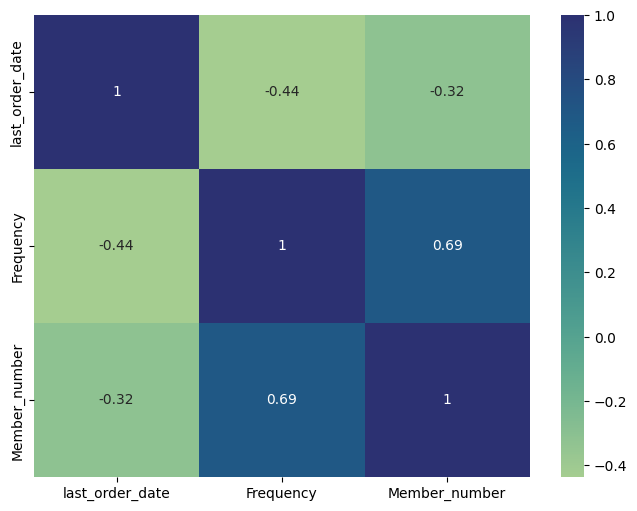

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(data = customers.corr(), annot=True, cmap = 'crest');

In [ ]:

# Rename columns
customers.rename(columns = {'last_order_date': 'Recency',
                            'Frequency': 'Frequency',
                            'Member_number': 'MonetaryValue'}, inplace=True)

In [ ]:
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,3898.0,187.959210,161.974174,1.0,58.0,140.0,281.0,728.0
Frequency,3898.0,9.944844,5.310796,2.0,6.0,9.0,13.0,36.0
MonetaryValue,3898.0,11542.164956,7499.426291,1019.0,5707.5,9780.0,15553.5,48640.0


In [ ]:
customers.head()

,Recency,Frequency,MonetaryValue
Member_number,,,
1000,36,13,5000
1001,261,12,5005
1002,123,8,4008
1003,90,8,4012
1004,322,21,8032


# Managing Skewness and Scaling

Text(0.5, 1.0, 'Histogram and Recency')

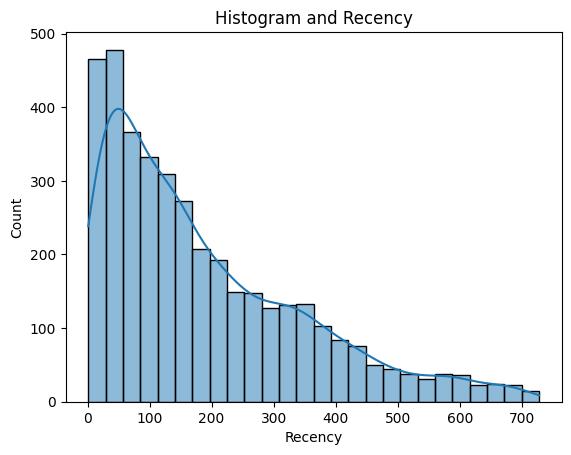

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Recency', kde=True)
ax.set_title('Histogram and Recency')

Text(0.5, 1.0, 'Histogram and Frequency')

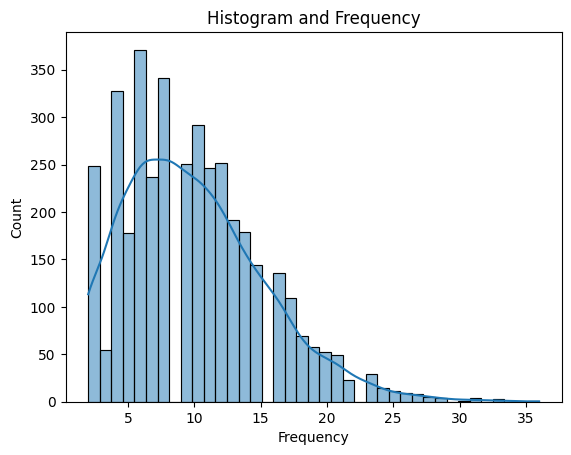

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Frequency', kde=True)
ax.set_title('Histogram and Frequency')

Text(0.5, 1.0, 'Histogram and MonetaryValue')

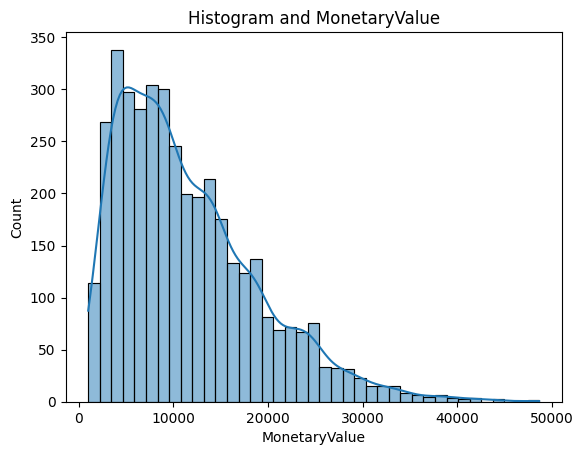

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='MonetaryValue', kde=True)
ax.set_title('Histogram and MonetaryValue')

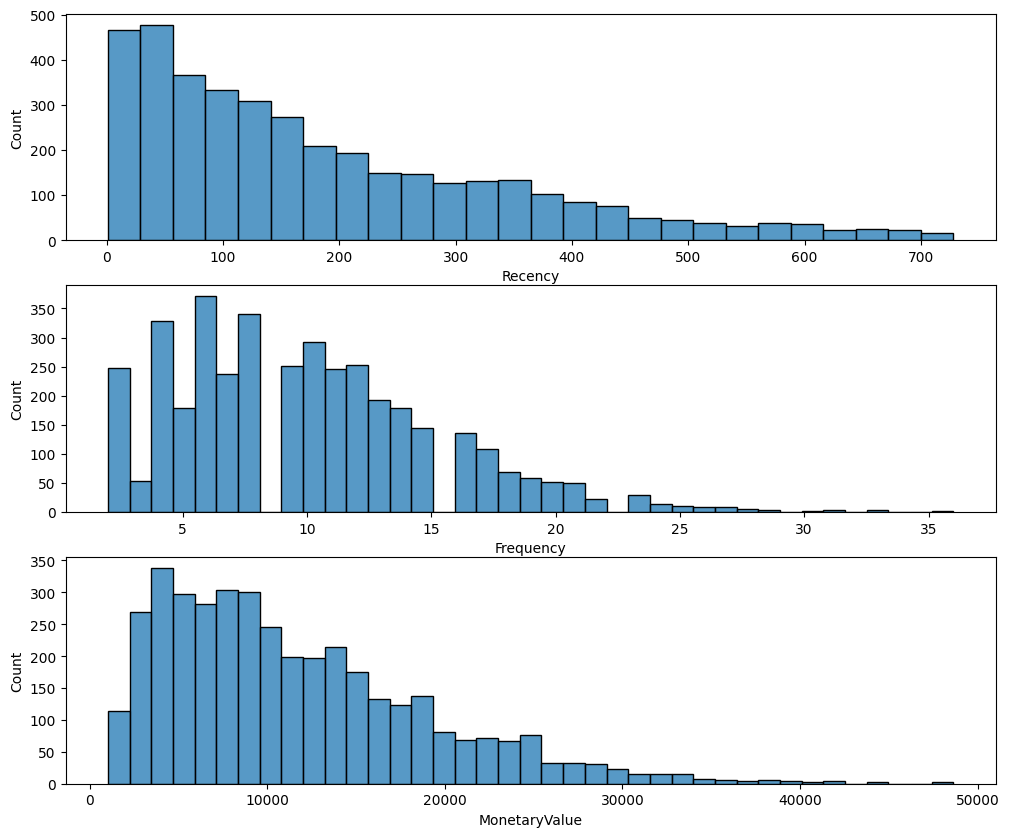

In [ ]:
# Plot RFM distributions

plt.figure(figsize=(12,10))

# Plot distribution of R
plt.subplot(3, 1, 1); sns.histplot(customers['Recency'])

# Plot distribution of F
plt.subplot(3, 1, 2); sns.histplot(customers['Frequency'])

# Plot distribution of M
plt.subplot(3, 1, 3); sns.histplot(customers['MonetaryValue'])
# Show the plot
plt.show()

# **RFM BOX-COX Transformation**

In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue
3893,6.817634,3.847542,36.660013
3894,1.746460,2.654617,32.934341
3895,9.506334,0.802660,27.333088
3896,2.107607,5.191431,43.924820
3897,10.100057,2.988455,36.667728


# RFM Transformation Distributions

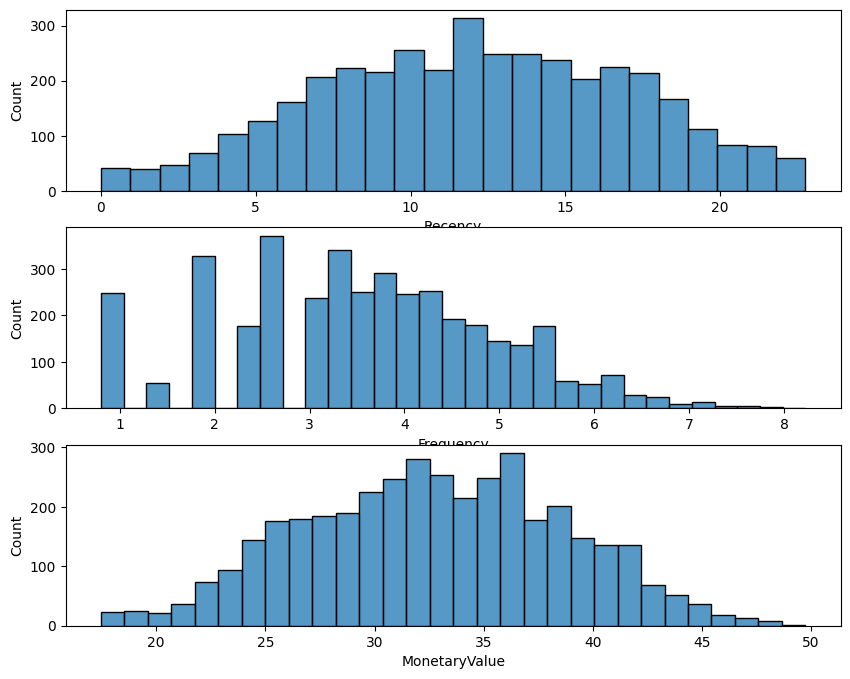

In [ ]:
# Plot RFM distributions

plt.figure(figsize=(10,8))

# Plot distribution of R
plt.subplot(3, 1, 1); sns.histplot(customers_fix['Recency'])

# Plot distribution of F
plt.subplot(3, 1, 2); sns.histplot(customers_fix['Frequency'])

# Plot distribution of M
plt.subplot(3, 1, 3); sns.histplot(customers_fix['MonetaryValue'])
# Show the plot
plt.show()

In [ ]:
# Import library

from sklearn.preprocessing import StandardScaler

# Initialize the Object

scaler = StandardScaler()

# Fit and Transform The Data

scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

# Assert that it has mean 0 and variance 1

print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


# **Using Elbow Method**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f09f2cd24d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTL

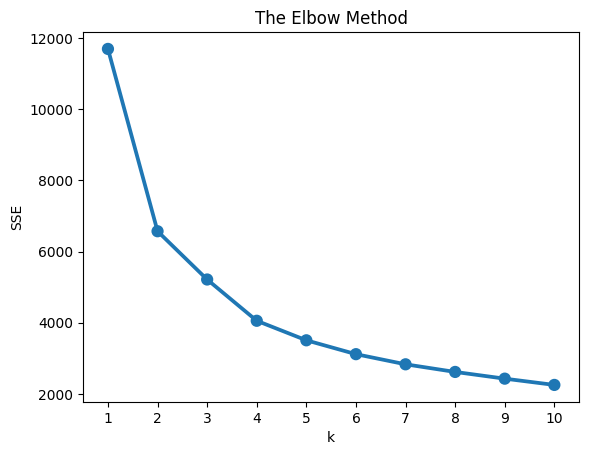

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

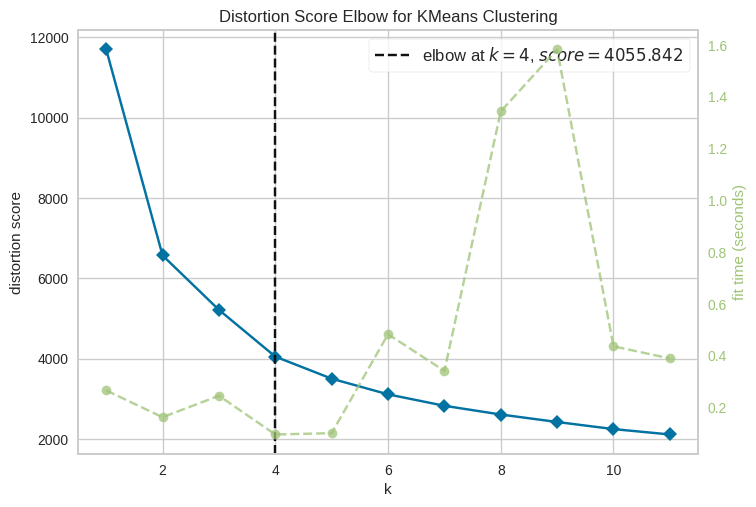

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(customers_normalized)
visualizer.show()

# **Fitting the Model**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,MonetaryValue
Cluster,,,
0,878,878,878
1,1007,1007,1007
2,1123,1123,1123
3,890,890,890


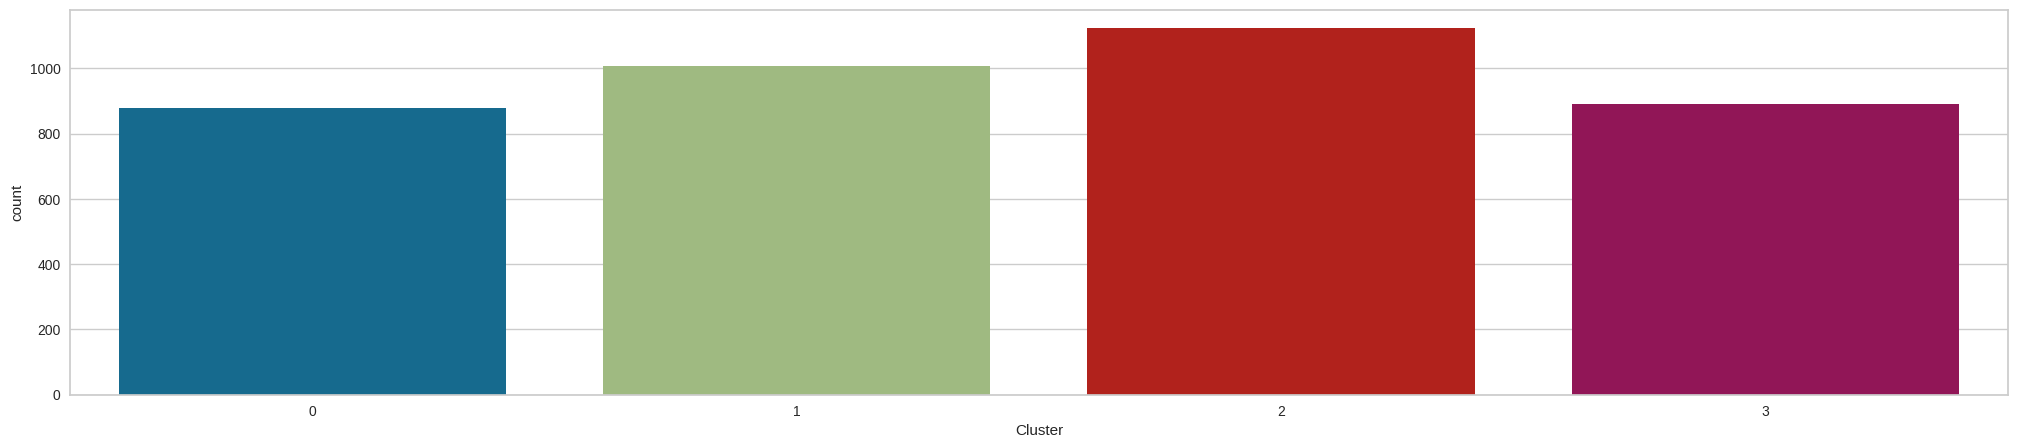

In [ ]:

model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=customers)
customers.groupby(['Cluster']).count()

# Calculating the RFM Mean

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        369.96      4.33       4540.32   878
1         70.46     16.14      19994.66  1007
2        249.28     10.31      12712.39  1123
3         63.98      8.01       7409.35   890

In [ ]:
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
Member_number,,,,
1000,36,13,5000,3
1001,261,12,5005,2
1002,123,8,4008,3
1003,90,8,4012,3
1004,322,21,8032,2


# **Visualising Using Snake Plot**

<Axes: xlabel='Attribute', ylabel='Value'>

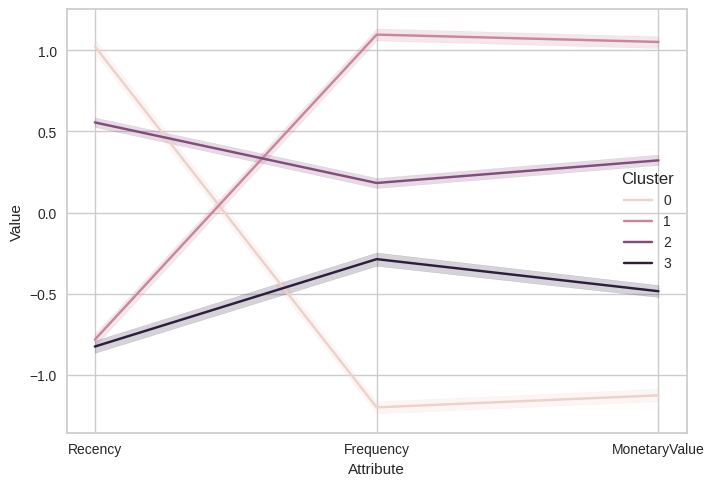

In [ ]:
# Create the dataframe

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')

df_nor_melt.head()

# Visualize it

sns.lineplot(x = 'Attribute', y= 'Value', hue='Cluster', data=df_nor_melt)

<Axes: xlabel='Recency', ylabel='Frequency'>

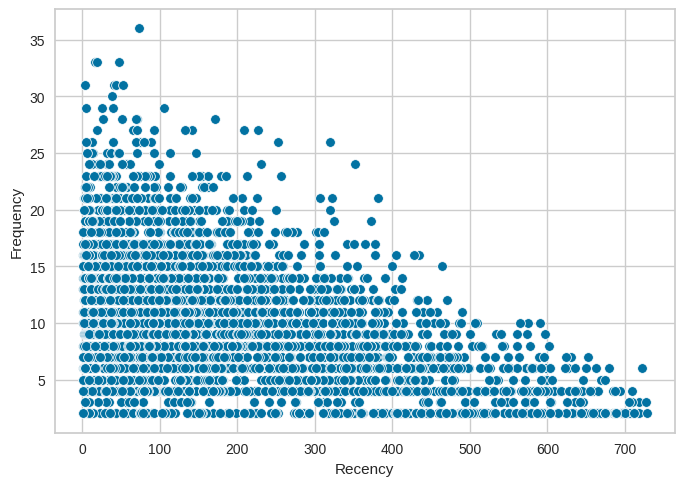

In [ ]:
# Scatterplot

sns.scatterplot(data=customers, x="Recency", y="Frequency")

<Axes: xlabel='MonetaryValue', ylabel='Frequency'>

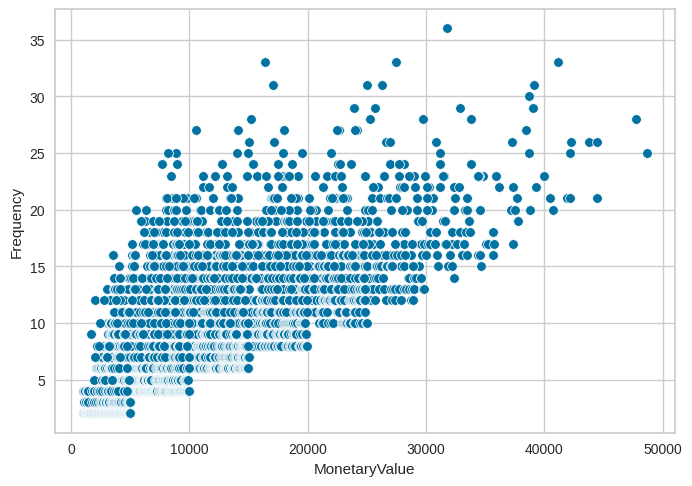

In [ ]:
sns.scatterplot(data=customers, x="MonetaryValue", y="Frequency")

# **Normalisation**

In [ ]:
	# Sklearn

	scaler = StandardScaler()
	data_scaled = scaler.fit_transform(customers)


	# Statistics of scaled data

	pd.DataFrame(data_scaled).describe()


,0,1,2,3
count,3.898000e+03,3.898000e+03,3.898000e+03,3.898000e+03
mean,3.098827e-17,-2.415262e-17,5.833086e-17,-7.655925e-17
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-1.154401e+00,-1.496172e+00,-1.403376e+00,-1.412797e+00
25%,-8.024482e-01,-7.428924e-01,-7.781147e-01,-4.830178e-01
50%,-2.961297e-01,-1.779328e-01,-2.350034e-01,4.467616e-01
75%,5.744911e-01,5.753466e-01,5.349542e-01,4.467616e-01
max,3.334544e+00,4.906703e+00,4.947391e+00,1.376541e+00


# **Modelling with K-means**

In [ ]:
# Defining the kmeans function with initialization as k-means++

kmeans = KMeans(n_clusters=4, init='k-means++')


# Fitting the k means algorithm on scaled data

y_kmeans = kmeans.fit(data_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = y_kmeans
frame['cluster'].value_counts()


KMeans(n_clusters=4)    3898
Name: cluster, dtype: int64

In [ ]:
# Inertia on the Fitted Data

kmeans.inertia_


4546.448854286509